In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import cv2
from ale_py import ALEInterface

In [51]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return resized / 255.0

def stack_frames(frames, frame, is_new_episode):
    if is_new_episode:
        frames = deque([frame] * 4, maxlen=4)
    else:
        frames.append(frame)
    stacked_frames = np.stack(frames, axis=0)
    return stacked_frames, frames

In [54]:
def train_dqn_v1():
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
    num_actions = env.action_space.n
    input_shape = (4, 84, 84)

    q_network = DQN(input_shape, num_actions)
    target_network = DQN(input_shape, num_actions)
    target_network.load_state_dict(q_network.state_dict())
    target_network.eval()

    optimizer = optim.Adam(q_network.parameters(), lr=0.0001)
    replay_buffer = deque(maxlen=100000)
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.995
    batch_size = 32
    update_target_steps = 1000
    rewards = []
    max_steps = 200
    episodes = 100

    frames = deque(maxlen=4)

    for episode in range(episodes):
        state = preprocess_frame(env.reset()[0])
        stacked_state, frames = stack_frames(frames, state, is_new_episode=True)
        total_reward = 0

        for step in range(max_steps):
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(stacked_state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            stacked_next_state, frames = stack_frames(frames, next_state, is_new_episode=False)

            replay_buffer.append((stacked_state, action, reward, stacked_next_state, done))
            stacked_state = stacked_next_state
            total_reward += reward

            if done or truncated:
                break

            if len(replay_buffer) >= batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states, actions, rewards_, next_states, dones = zip(*minibatch)

                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                rewards_ = torch.tensor(rewards_, dtype=torch.float32)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                q_values = q_network(states).gather(1, actions).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_network(next_states).max(1)[0]
                targets = rewards_ + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if step % update_target_steps == 0:
                target_network.load_state_dict(q_network.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)

        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    env.close()
    return q_network, rewards
q_network, rewards = train_dqn_v1()

Episode 0, Total Reward: 3.0, Epsilon: 0.99
Episode 1, Total Reward: 1.0, Epsilon: 0.99
Episode 2, Total Reward: 3.0, Epsilon: 0.99
Episode 3, Total Reward: 0.0, Epsilon: 0.98
Episode 4, Total Reward: 1.0, Epsilon: 0.98
Episode 5, Total Reward: 0.0, Epsilon: 0.97
Episode 6, Total Reward: 2.0, Epsilon: 0.97
Episode 7, Total Reward: 2.0, Epsilon: 0.96
Episode 8, Total Reward: 1.0, Epsilon: 0.96
Episode 9, Total Reward: 1.0, Epsilon: 0.95
Episode 10, Total Reward: 2.0, Epsilon: 0.95
Episode 11, Total Reward: 2.0, Epsilon: 0.94
Episode 12, Total Reward: 1.0, Epsilon: 0.94
Episode 13, Total Reward: 1.0, Epsilon: 0.93
Episode 14, Total Reward: 1.0, Epsilon: 0.93
Episode 15, Total Reward: 0.0, Epsilon: 0.92
Episode 16, Total Reward: 0.0, Epsilon: 0.92
Episode 17, Total Reward: 0.0, Epsilon: 0.91
Episode 18, Total Reward: 4.0, Epsilon: 0.91
Episode 19, Total Reward: 1.0, Epsilon: 0.90
Episode 20, Total Reward: 2.0, Epsilon: 0.90
Episode 21, Total Reward: 1.0, Epsilon: 0.90
Episode 22, Total Re

In [52]:
def train_dqn_v2():
    env = gym.make("ALE/Breakout-v5", frameskip=4)
    num_actions = env.action_space.n
    input_shape = (4, 84, 84)

    device = torch.device("cpu")
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    q_network = DQN(input_shape, num_actions).to(device)
    target_network = DQN(input_shape, num_actions).to(device)
    target_network.load_state_dict(q_network.state_dict())
    target_network.eval()

    optimizer = optim.Adam(q_network.parameters(), lr=0.0001)
    replay_buffer = deque(maxlen=100000)
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.995
    batch_size = 1024
    episodes = 100
    max_steps = 200
    update_target_steps = 1000
    rewards = []

    frames = deque(maxlen=4)

    for episode in range(episodes):
        state = preprocess_frame(env.reset()[0])
        stacked_state, frames = stack_frames(frames, state, is_new_episode=True)
        total_reward = 0

        for step in range(max_steps):
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(stacked_state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            stacked_next_state, frames = stack_frames(frames, next_state, is_new_episode=False)

            replay_buffer.append((stacked_state, action, reward, stacked_next_state, done))
            stacked_state = stacked_next_state
            total_reward += reward

            if done or truncated:
                break

            if len(replay_buffer) >= batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states, actions, rewards_, next_states, dones = zip(*minibatch)

                states = torch.tensor(np.array(states), dtype=torch.float32).to(device)  # [Batch_size, 4, 84, 84]
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)  # [Batch_size, 1]
                rewards_ = torch.tensor(rewards_, dtype=torch.float32).to(device)  # [Batch_size]
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)  # [Batch_size, 4, 84, 84]
                dones = torch.tensor(dones, dtype=torch.float32).to(device)  # [Batch_size]

                q_values = q_network(states).gather(1, actions).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_network(next_states).max(1)[0]
                targets = rewards_ + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if step % update_target_steps == 0:
                target_network.load_state_dict(q_network.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)

        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    env.close()
    return q_network, rewards

q_network, rewards = train_dqn_v2()

Using device: mps
Episode 0, Total Reward: 0.0, Epsilon: 0.99
Episode 1, Total Reward: 1.0, Epsilon: 0.99
Episode 2, Total Reward: 1.0, Epsilon: 0.99
Episode 3, Total Reward: 2.0, Epsilon: 0.98
Episode 4, Total Reward: 2.0, Epsilon: 0.98
Episode 5, Total Reward: 0.0, Epsilon: 0.97
Episode 6, Total Reward: 0.0, Epsilon: 0.97
Episode 7, Total Reward: 1.0, Epsilon: 0.96
Episode 8, Total Reward: 1.0, Epsilon: 0.96
Episode 9, Total Reward: 0.0, Epsilon: 0.95
Episode 10, Total Reward: 1.0, Epsilon: 0.95
Episode 11, Total Reward: 1.0, Epsilon: 0.94
Episode 12, Total Reward: 0.0, Epsilon: 0.94
Episode 13, Total Reward: 0.0, Epsilon: 0.93
Episode 14, Total Reward: 1.0, Epsilon: 0.93
Episode 15, Total Reward: 2.0, Epsilon: 0.92
Episode 16, Total Reward: 2.0, Epsilon: 0.92
Episode 17, Total Reward: 2.0, Epsilon: 0.91
Episode 18, Total Reward: 1.0, Epsilon: 0.91
Episode 19, Total Reward: 1.0, Epsilon: 0.90
Episode 20, Total Reward: 2.0, Epsilon: 0.90
Episode 21, Total Reward: 2.0, Epsilon: 0.90
Ep

KeyboardInterrupt: 

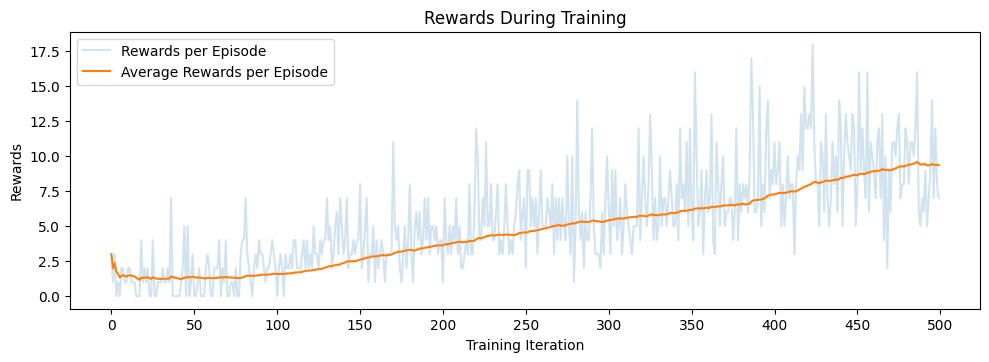

In [57]:
window_size = 100
smoothed_reward = [np.mean(rewards[max(0, i - window_size):i + 1]) for i in range(len(rewards))]

plt.figure(figsize=(10,10))
steps = 100

plt.subplot(3, 1, 1)
plt.plot(rewards, alpha=0.2, label="Rewards per Episode")
plt.plot(smoothed_reward, label="Average Rewards per Episode")
plt.xlabel("Training Iteration")
plt.ylabel("Rewards")
plt.title("Rewards During Training")
plt.xticks(range(0, 501, 50))
plt.legend()
# Show the plots
plt.tight_layout()
plt.show()

In [58]:
torch.save(q_network.state_dict(), f'DQN_Breakout_Episodes_{500}.pt')

In [46]:
# DQN-Modell
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Preprocess Frame
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return resized / 255.0

# Stack Frames
def stack_frames(frames, frame, is_new_episode):
    if is_new_episode:
        frames = deque([frame] * 4, maxlen=4)
    else:
        frames.append(frame)
    stacked_frames = np.stack(frames, axis=0)
    return stacked_frames, frames

# Training ohne Replay Buffer und Target Network
def train_dqn_no_buffer():
    env = gym.make("ALE/Breakout-v5", frameskip=4)
    num_actions = env.action_space.n
    input_shape = (4, 84, 84)

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    q_network = DQN(input_shape, num_actions).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=0.0001)
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.995
    episodes = 1000
    max_steps = 200
    rewards = []

    frames = deque(maxlen=4)

    for episode in range(episodes):
        state = preprocess_frame(env.reset()[0])
        stacked_state, frames = stack_frames(frames, state, is_new_episode=True)
        total_reward = 0

        for step in range(max_steps):
            # Epsilon-greedy Policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(stacked_state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()

            # Execute Action
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            stacked_next_state, frames = stack_frames(frames, next_state, is_new_episode=False)

            # Q-Learning Update
            state_tensor = torch.tensor(stacked_state, dtype=torch.float32).unsqueeze(0).to(device)
            next_state_tensor = torch.tensor(stacked_next_state, dtype=torch.float32).unsqueeze(0).to(device)
            action_tensor = torch.tensor([action], dtype=torch.int64).unsqueeze(0).to(device)
            reward_tensor = torch.tensor([reward], dtype=torch.float32).to(device)

            # Q-Werte berechnen
            q_values = q_network(state_tensor).gather(1, action_tensor)
            with torch.no_grad():
                max_next_q_value = q_network(next_state_tensor).max(1)[0]
            target = reward_tensor + gamma * max_next_q_value * (1 - done)

            # Verlust berechnen und Optimierung durchführen
            loss = nn.MSELoss()(q_values, target.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            stacked_state = stacked_next_state
            total_reward += reward

            if done or truncated:
                break

        # Epsilon reduzieren
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)

        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    env.close()
    return q_network, rewards

# Training starten
# Runtime 31m 42s
q_network, rewards = train_dqn_no_buffer()

Using device: mps
Episode 0, Total Reward: 2.0, Epsilon: 0.99
Episode 1, Total Reward: 1.0, Epsilon: 0.99
Episode 2, Total Reward: 3.0, Epsilon: 0.99
Episode 3, Total Reward: 0.0, Epsilon: 0.98
Episode 4, Total Reward: 1.0, Epsilon: 0.98
Episode 5, Total Reward: 0.0, Epsilon: 0.97
Episode 6, Total Reward: 0.0, Epsilon: 0.97
Episode 7, Total Reward: 3.0, Epsilon: 0.96
Episode 8, Total Reward: 0.0, Epsilon: 0.96
Episode 9, Total Reward: 0.0, Epsilon: 0.95
Episode 10, Total Reward: 1.0, Epsilon: 0.95
Episode 11, Total Reward: 3.0, Epsilon: 0.94
Episode 12, Total Reward: 1.0, Epsilon: 0.94
Episode 13, Total Reward: 3.0, Epsilon: 0.93
Episode 14, Total Reward: 0.0, Epsilon: 0.93
Episode 15, Total Reward: 1.0, Epsilon: 0.92
Episode 16, Total Reward: 1.0, Epsilon: 0.92
Episode 17, Total Reward: 1.0, Epsilon: 0.91
Episode 18, Total Reward: 2.0, Epsilon: 0.91
Episode 19, Total Reward: 2.0, Epsilon: 0.90
Episode 20, Total Reward: 0.0, Epsilon: 0.90
Episode 21, Total Reward: 2.0, Epsilon: 0.90
Ep

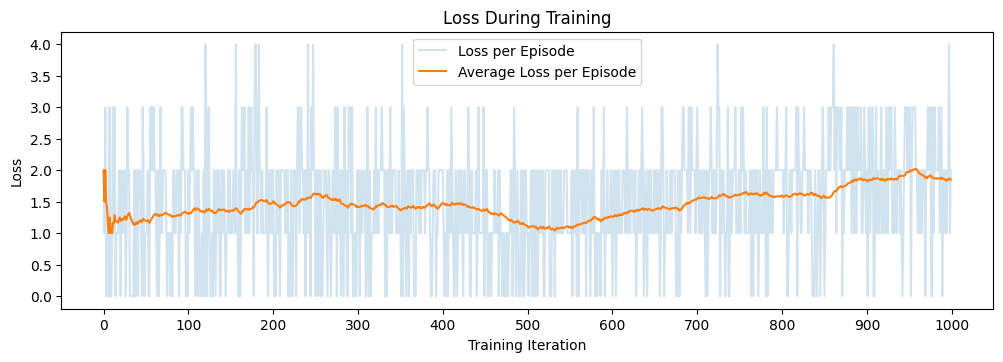

In [50]:
window_size = 100
smoothed_reward = [np.mean(rewards[max(0, i - window_size):i + 1]) for i in range(len(rewards))]

plt.figure(figsize=(10,10))
steps = 100

plt.subplot(3, 1, 1)
plt.plot(rewards, alpha=0.2, label="Loss per Episode")
plt.plot(smoothed_reward, label="Average Loss per Episode")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.xticks(range(0, 1001, 100))
plt.legend()
# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import cv2
from ale_py import ALEInterface

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return resized / 255.0

def stack_frames(frames, frame, is_new_episode):
    if is_new_episode:
        frames = deque([frame] * 4, maxlen=4)
    else:
        frames.append(frame)
    stacked_frames = np.stack(frames, axis=0)
    return stacked_frames, frames

def train_dqn_v1():
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
    num_actions = env.action_space.n
    input_shape = (4, 84, 84)

    q_network = DQN(input_shape, num_actions)
    target_network = DQN(input_shape, num_actions)
    target_network.load_state_dict(q_network.state_dict())
    target_network.eval()

    optimizer = optim.Adam(q_network.parameters(), lr=0.0001)
    replay_buffer = deque(maxlen=100000)
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.995
    batch_size = 32
    update_target_steps = 1000
    rewards = []
    max_steps = 200
    episodes = 100

    frames = deque(maxlen=4)

    for episode in range(episodes):
        state = preprocess_frame(env.reset()[0])
        stacked_state, frames = stack_frames(frames, state, is_new_episode=True)
        total_reward = 0

        for step in range(max_steps):
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(stacked_state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            stacked_next_state, frames = stack_frames(frames, next_state, is_new_episode=False)

            replay_buffer.append((stacked_state, action, reward, stacked_next_state, done))
            stacked_state = stacked_next_state
            total_reward += reward

            if done or truncated:
                break

            if len(replay_buffer) >= batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states, actions, rewards_, next_states, dones = zip(*minibatch)

                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                rewards_ = torch.tensor(rewards_, dtype=torch.float32)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                q_values = q_network(states).gather(1, actions).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_network(next_states).max(1)[0]
                targets = rewards_ + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if step % update_target_steps == 0:
                target_network.load_state_dict(q_network.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)

        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    env.close()
    return q_network, rewards

q_network, rewards = train_dqn_v1()


**Reflection**
- Durch CNN sorgt dafür dass die wichtigsten Merkmale extrahiert werden. Es reduziert die Daten auf eine niedrigere Dimension das hat den Vorteil, dass der Agent sich auf die wichtigen Merkmale fokussieren kann und  nicht unübersichtlichen Pixelwerten arbeiten muss.
Denn Rohpixeldaten enthalten oftmals irrelevante Informationen (Hintergrund, Rand des Spielfelds). Zudem ist es möglich das CNNs die Bewegungsinformationen zu erlernen, somit kann der Agent also voraussagen, wo der Ball landen wird.